In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease


In [2]:
df = pd.read_csv ('Data/PolymerFloodingParm_SensitivityAnalysis.csv', index_col = "ID")
df.head()

,Adsorption,IPV,Injection_Pressure,Injection_Rate,Injection_Time,RRF,OilRecovery
ID,,,,,,,
1,0.300000,0.200000,2000.0000,670.00000,916.00000,3.000000,30.961008
2,0.550000,0.322727,2024.3902,700.00000,665.14634,2.772727,31.047777
3,0.331818,0.268182,1882.9268,509.75610,976.85366,3.727273,32.630894
4,0.259091,0.213636,2136.5854,875.60976,821.00000,3.409091,25.987240
5,0.404545,0.131818,1834.1463,780.48780,493.70732,2.772727,30.031294


## EDA and Data Processing

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

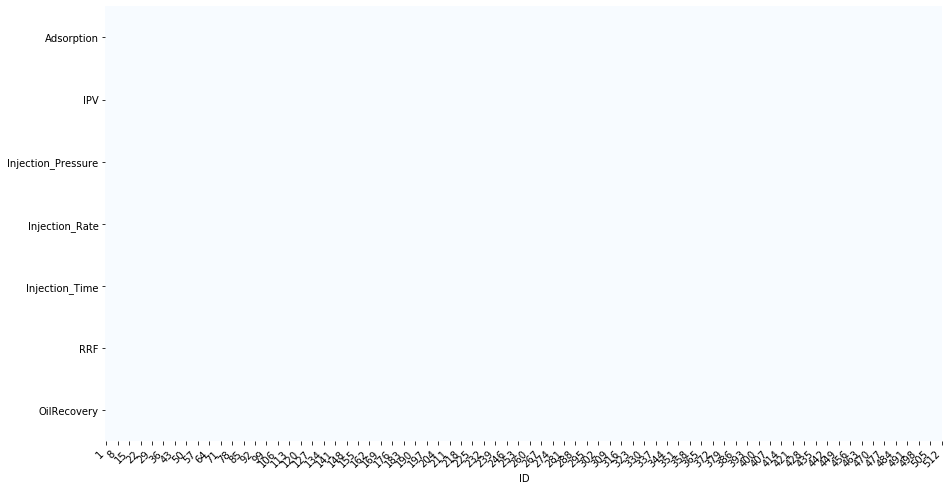

In [4]:
plot_missing_value(df)

In [5]:
df.columns

Index(['Adsorption', 'IPV', 'Injection_Pressure', 'Injection_Rate',
       'Injection_Time', 'RRF', 'OilRecovery'],
      dtype='object')

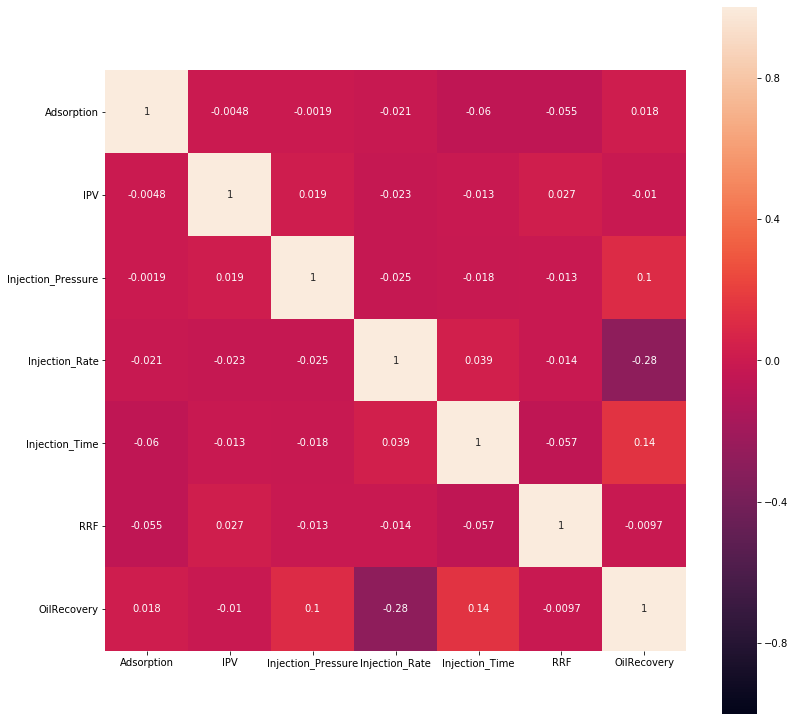

In [6]:
plt.figure(figsize=(13, 13))
sns.heatmap(df.corr(), cbar='False', vmin=-1, vmax=1, annot=True, square=True)
plt.savefig('Heatmap_Parameter.png', dpi = 300)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018D3649DD88>,
      dtype=object)

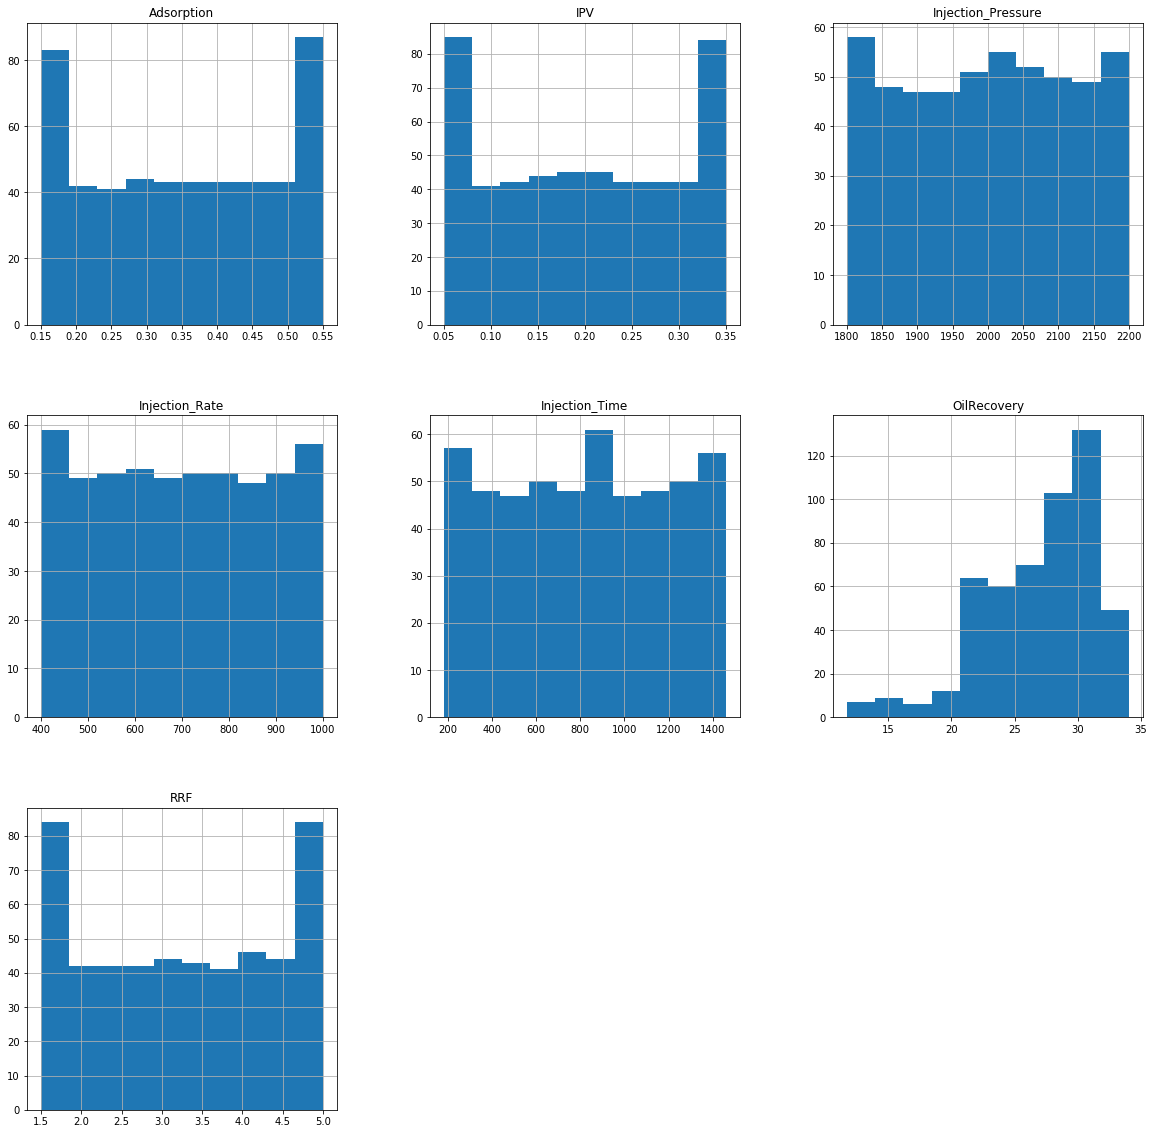

In [7]:
df.hist(figsize=(20, 20))

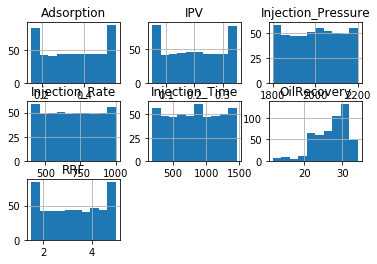

In [8]:
df.hist()
plt.savefig('df.png', dpi = 300)

## Normalization Data

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()
scaler.fit(df)
df_norm = scaler.transform(df)

In [11]:
df_norm

array([[0.375     , 0.5       , 0.5       , ..., 0.5743349 , 0.42857143,
        0.86147193],
       [1.        , 0.9090909 , 0.5609755 , ..., 0.37804878, 0.36363637,
        0.86536175],
       [0.45454545, 0.72727273, 0.207317  , ..., 0.62195122, 0.63636363,
        0.93633229],
       ...,
       [0.0909091 , 0.        , 0.18292675, ..., 0.45121951, 0.54545454,
        0.88588426],
       [0.72727272, 0.09090909, 0.42682925, ..., 0.85365853, 0.36363637,
        0.68134734],
       [0.18181817, 0.72727273, 0.487805  , ..., 0.02439024, 0.81818183,
        0.00427092]])

## Machine Learning Modelling

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [13]:
df.columns

Index(['Adsorption', 'IPV', 'Injection_Pressure', 'Injection_Rate',
       'Injection_Time', 'RRF', 'OilRecovery'],
      dtype='object')

In [14]:
X = df.drop(columns='OilRecovery')
y = df.OilRecovery

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((460, 6), (52, 6), (460,), (52,))

In [15]:
X_train.columns

Index(['Adsorption', 'IPV', 'Injection_Pressure', 'Injection_Rate',
       'Injection_Time', 'RRF'],
      dtype='object')

## X-Gradient Boosting

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error
from jcopml.plot import plot_actual_vs_prediction, plot_residual
from jcopml.feature_importance import mean_loss_decrease, mean_score_decrease
from jcopml.utils import load_model
from jcopml.utils import save_model

In [17]:
rsp.xgb_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [18]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax', poly=1), ['Adsorption', 'IPV', 'RRF', 'Injection_Pressure', 'Injection_Time',
       'Injection_Rate']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model_XGB = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_XGB.fit(X_train, y_train)

print(model_XGB.best_params_)
print(model_XGB.score(X_train, y_train), model_XGB.best_score_, model_XGB.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s


{'algo__colsample_bytree': 0.9763799669573133, 'algo__gamma': 3, 'algo__learning_rate': 0.05820013372709852, 'algo__max_depth': 4, 'algo__n_estimators': 163, 'algo__reg_alpha': 0.07362945281639222, 'algo__reg_lambda': 2.752717392942944, 'algo__subsample': 0.6401537692938899}
0.9890639617988631 0.9660663578419987 0.9660495139300008


[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    6.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.3s finished


In [19]:
model_XGB.score(X_train, y_train), model_XGB.score(X_test, y_test)

(0.9890639617988631, 0.9660495139300008)

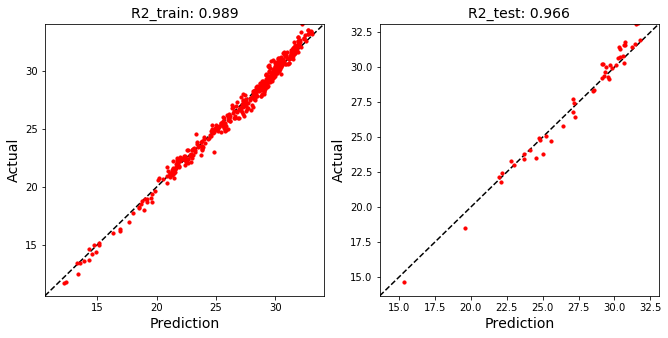

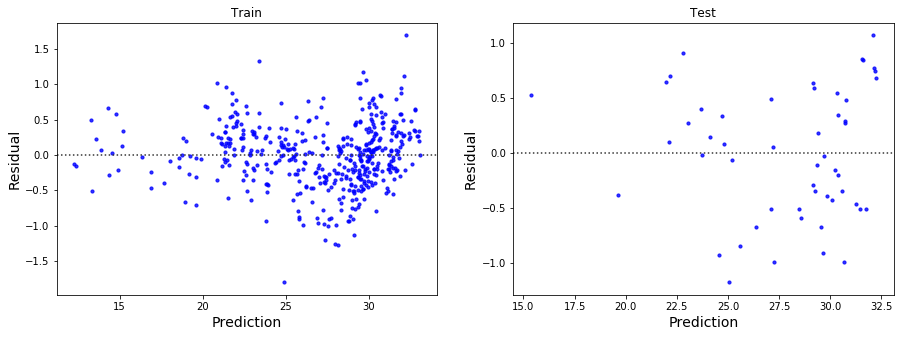

In [20]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_XGB)
plt.savefig('Actual_train_testing2.png', dpi = 300)
plot_residual(X_train, y_train, X_test, y_test, model_XGB)
plt.savefig('Residual_train_testing2.png', dpi = 300)

In [21]:
y_true = y_test
y_pred = model_XGB.predict(X_test)

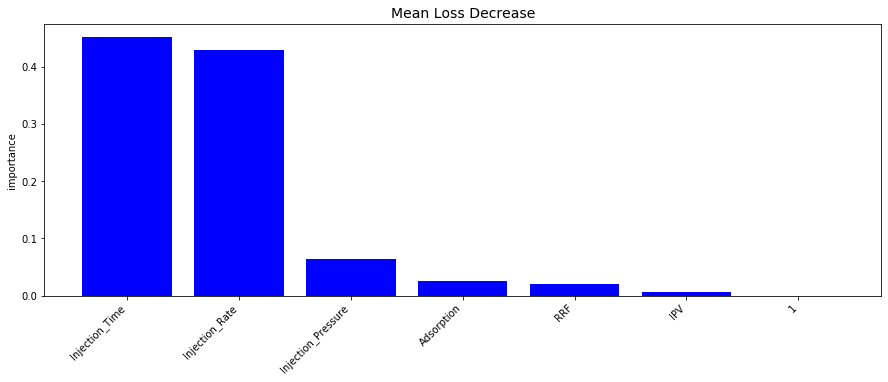

In [22]:
df_imp= mean_loss_decrease(X_train, model_XGB, plot = True)
plt.savefig('mean_loss_decrease.png', dpi = 300)

In [23]:
df_imp.head()

,feature,importance
5,Injection_Time,0.452632
6,Injection_Rate,0.430075
4,Injection_Pressure,0.064662
1,Adsorption,0.025564
3,RRF,0.021053


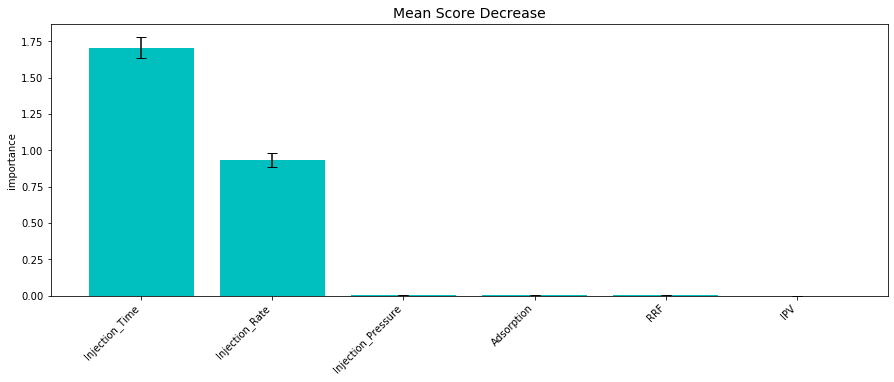

In [24]:
df_imp = mean_score_decrease(X_train, y_train, model_XGB, plot=True, topk=6)

In [25]:
save_model (model_XGB, 'SensitivityAnalysis_PolymerFlooding')

Model is pickled as model/SensitivityAnalysis_PolymerFlooding


## Finishing

In [26]:
OilRecovery_test = model_XGB.predict(X_test)
OilRecovery_train = model_XGB.predict(X_train)

In [27]:
load_model ('model/SensitivityAnalysis_PolymerFlooding')

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('prep',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('numeric',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                         

In [28]:
X_train.head()

,Adsorption,IPV,Injection_Pressure,Injection_Rate,Injection_Time,RRF
ID,,,,,,
483,0.513636,0.050000,2117.0732,641.46341,602.80488,4.681818
64,0.440909,0.295455,1985.3659,487.80488,836.58537,4.681818
456,0.513636,0.077273,1878.0488,597.56098,1413.24390,3.090909
71,0.259091,0.186364,1965.8537,839.02439,400.19512,3.409091
3,0.331818,0.268182,1882.9268,509.75610,976.85366,3.727273


In [29]:
df.columns

Index(['Adsorption', 'IPV', 'Injection_Pressure', 'Injection_Rate',
       'Injection_Time', 'RRF', 'OilRecovery'],
      dtype='object')

In [30]:
input_variable_test = df.drop(columns = 'OilRecovery')

In [31]:
input_variable_test.head ()

,Adsorption,IPV,Injection_Pressure,Injection_Rate,Injection_Time,RRF
ID,,,,,,
1,0.300000,0.200000,2000.0000,670.00000,916.00000,3.000000
2,0.550000,0.322727,2024.3902,700.00000,665.14634,2.772727
3,0.331818,0.268182,1882.9268,509.75610,976.85366,3.727273
4,0.259091,0.213636,2136.5854,875.60976,821.00000,3.409091
5,0.404545,0.131818,1834.1463,780.48780,493.70732,2.772727


In [32]:
OilRecovery_Predict_XGB = model_XGB.predict(input_variable_test)
df.insert (6, column = 'OilRecovery_XGB', value = OilRecovery_Predict_XGB, allow_duplicates = False)

In [33]:
df.head(21)

,Adsorption,IPV,Injection_Pressure,Injection_Rate,Injection_Time,RRF,OilRecovery_XGB,OilRecovery
ID,,,,,,,,
1,0.300000,0.200000,2000.0000,670.00000,916.00000,3.000000,29.818251,30.961008
2,0.550000,0.322727,2024.3902,700.00000,665.14634,2.772727,30.392126,31.047777
3,0.331818,0.268182,1882.9268,509.75610,976.85366,3.727273,31.919903,32.630894
4,0.259091,0.213636,2136.5854,875.60976,821.00000,3.409091,26.879185,25.987240
5,0.404545,0.131818,1834.1463,780.48780,493.70732,2.772727,30.005161,30.031294
6,0.477273,0.159091,2200.0000,868.29268,1085.95120,1.500000,23.563940,23.542797
7,0.404545,0.295455,1975.6098,626.82927,883.34146,3.090909,30.616308,30.827679
8,0.295455,0.159091,2034.1463,809.75610,1335.31710,3.409091,23.861622,23.589645
9,0.440909,0.240909,1829.2683,956.09756,1054.78050,3.727273,22.370558,22.329521


In [34]:
df.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            503, 504, 505, 506, 507, 508, 509, 510, 511, 512],
           dtype='int64', name='ID', length=512)

In [35]:
df.reset_index(inplace=True)
df

,ID,Adsorption,IPV,Injection_Pressure,Injection_Rate,Injection_Time,RRF,OilRecovery_XGB,OilRecovery
0,1,0.300000,0.200000,2000.0000,670.00000,916.00000,3.000000,29.818251,30.961008
1,2,0.550000,0.322727,2024.3902,700.00000,665.14634,2.772727,30.392126,31.047777
2,3,0.331818,0.268182,1882.9268,509.75610,976.85366,3.727273,31.919903,32.630894
3,4,0.259091,0.213636,2136.5854,875.60976,821.00000,3.409091,26.879185,25.987240
4,5,0.404545,0.131818,1834.1463,780.48780,493.70732,2.772727,30.005161,30.031294
...,...,...,...,...,...,...,...,...,...
507,508,0.550000,0.213636,2082.9268,429.26829,883.34146,2.772727,32.149967,32.070412
508,509,0.368182,0.159091,2004.8780,919.51220,1054.78050,3.727273,22.919725,22.890135
509,510,0.186364,0.050000,1873.1707,582.92683,758.65854,3.409091,31.314159,31.505566
510,511,0.440909,0.077273,1970.7317,648.78049,1272.97560,2.772727,27.138531,26.943027


In [36]:
def get_rmse (y_true, y_pred):
    return np.sqrt (np.mean((y_pred-y_true)**2.00))
def get_rel_l2_error(y_true, y_pred):
    return np.linalg.norm(y_true-y_pred, 2) / np.linalg.norm(y_true, 2)

In [38]:
X1 = df.ID
y1 = df.OilRecovery
y2 = df.OilRecovery_XGB

Text(0, 0.5, 'OilRecovery')

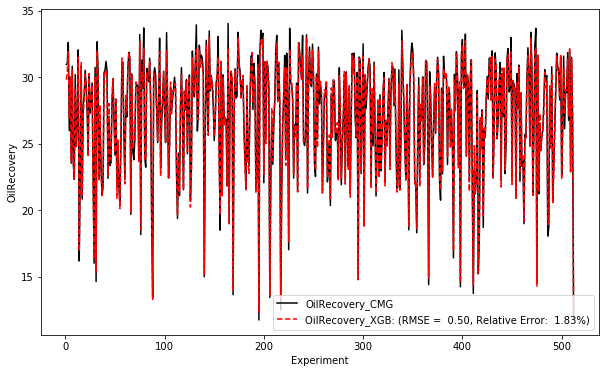

In [39]:
fig = plt.figure(figsize= (10, 6))
ax = plt.axes()

rmse_XG = get_rmse(df['OilRecovery'], df['OilRecovery_XGB']) 
l2_XG = get_rel_l2_error(df['OilRecovery'], df['OilRecovery_XGB']) * 100

ax.plot(X1, y1, 'k-', label = 'OilRecovery_CMG')
ax.plot(X1, y2, 'r--', label = f'OilRecovery_XGB: (RMSE = {rmse_XG: .2f}, Relative Error: {l2_XG: .2f}%)')

ax.legend()
plt.xlabel('Experiment')
plt.ylabel('OilRecovery')